# Train ALL 4 Classification Models (Optimized)
**Author:** G8  
**Task:** 2.1 - Train 4 CNN Models  
**Strategy:** Unfreeze top layers for ALL transfer learning models  

**Models:**
1. Custom CNN (simplified architecture)
2. ResNet50 (with unfrozen top 30 layers)
3. EfficientNet-B0 (with unfrozen top 20 layers)
4. MobileNetV2 (with unfrozen top 20 layers)
5. **Advanced CNN (Task 3a/3b/3c optimized architecture)**

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

print("Setup complete")

print("Libraries imported!")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

Setup complete
Libraries imported!
TensorFlow: 2.16.2
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Config
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "single_objects"
MODELS_PATH = PROJECT_ROOT / "models" / "classification"
LOGS_PATH = PROJECT_ROOT / "logs" / "classification"

MODELS_PATH.mkdir(parents=True, exist_ok=True)
LOGS_PATH.mkdir(parents=True, exist_ok=True)

with open(PROJECT_ROOT / "data" / "class_mapping.json", 'r') as f:
    class_info = json.load(f)
NUM_CLASSES = class_info['num_classes']

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30  # Start with 5 for testing

print(f"Classes: {NUM_CLASSES}")

Classes: 39


In [3]:
# Data generators with stronger augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,               # Increased for more face angle variety
    width_shift_range=0.25,          # Horizontal shift
    height_shift_range=0.25,         # Vertical shift
    shear_range=0.2,                 # Light shear for pose variation
    zoom_range=0.25,                 # Zoom in/out for distance changes
    horizontal_flip=True,            # Flip horizontally (faces are symmetric)
    brightness_range=[0.7, 1.35],    # Strong brightness variation for lighting
    channel_shift_range=25.0,        # Color channel shift for robustness
    fill_mode='nearest'
)

# Validation & Test: only rescale (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(
    DATA_PATH / 'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    DATA_PATH / 'val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Train: {train_gen.samples}, Val: {val_gen.samples}")

Found 2943 images belonging to 39 classes.
Found 656 images belonging to 39 classes.
Train: 2943, Val: 656


## Model 1: Custom CNN (Simplified)

In [4]:
def build_custom_cnn():
    """Simplified custom CNN with better regularization"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        # Classifier
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Higher LR for from-scratch
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building Custom CNN...")
model_cnn = build_custom_cnn()
print(f"Params: {model_cnn.count_params():,}")

Building Custom CNN...


/Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-05 00:24:10.974160: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-02-05 00:24:10.974228: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-05 00:24:10.974235: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-05 00:24:10.974342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-05 00:24:10.974417: I

Params: 1,697,191


In [5]:
# Train Custom CNN
print("="*80)
print("TRAINING CUSTOM CNN")
print("="*80)

callbacks_cnn = [
    ModelCheckpoint(str(MODELS_PATH / 'custom_cnn_best.keras'), monitor='val_accuracy', 
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history_cnn = model_cnn.fit(
    train_gen, epochs=EPOCHS, validation_data=val_gen,
    callbacks=callbacks_cnn, verbose=1
)

model_cnn.save(MODELS_PATH / 'custom_cnn_last.keras')
print(f"\nBest: {max(history_cnn.history['val_accuracy']):.4f}")

TRAINING CUSTOM CNN
Epoch 1/30


2026-02-05 00:24:12.384490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0939 - loss: 4.1482
Epoch 1: val_accuracy improved from None to 0.02287, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/custom_cnn_best.keras

Epoch 1: finished saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/custom_cnn_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1502 - loss: 3.6612 - val_accuracy: 0.0229 - val_loss: 5.6867 - learning_rate: 5.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.2498 - loss: 2.9915
Epoch 2: val_accuracy improved from 0.02287 to 0.06860, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/custom_cnn_best.keras

Epoch 2: fi

## Model 2: ResNet50 (Fine-tuned)

In [6]:
def build_resnet50():
    """ResNet50 with top layers unfrozen for fine-tuning"""
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze top 30 layers
    base.trainable = True
    for layer in base.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Higher for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building ResNet50...")
model_resnet = build_resnet50()
trainable = sum([tf.size(w).numpy() for w in model_resnet.trainable_weights])
print(f"Trainable params: {trainable:,}")

Building ResNet50...
Trainable params: 15,523,367


In [7]:
# Train ResNet50
print("="*80)
print("TRAINING RESNET50")
print("="*80)

callbacks_resnet = [
    ModelCheckpoint(str(MODELS_PATH / 'resnet50_best.keras'), monitor='val_accuracy',
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history_resnet = model_resnet.fit(
    train_gen, epochs=EPOCHS, validation_data=val_gen,
    callbacks=callbacks_resnet, verbose=1
)

model_resnet.save(MODELS_PATH / 'resnet50_last.keras')
print(f"\nBest: {max(history_resnet.history['val_accuracy']):.4f}")

TRAINING RESNET50
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.0905 - loss: 4.7331
Epoch 1: val_accuracy improved from None to 0.03201, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/resnet50_best.keras

Epoch 1: finished saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/resnet50_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 675ms/step - accuracy: 0.1233 - loss: 4.2990 - val_accuracy: 0.0320 - val_loss: 5.9279 - learning_rate: 5.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.1948 - loss: 3.6067
Epoch 2: val_accuracy did not improve from 0.03201
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 663ms/step - accuracy: 0.2001 - loss: 3.5631 - val_accuracy: 0.0244 - val_loss: 6.1545 - learning_rate: 5.0000e-04
Epoch 3/30
92/92 ━━━━━━━━━━

## Model 3: EfficientNet-B0 (Fine-tuned)

In [8]:
def build_efficientnet():
    """EfficientNet with top layers unfrozen"""
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze top 20 layers
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building EfficientNet...")
model_eff = build_efficientnet()
trainable = sum([tf.size(w).numpy() for w in model_eff.trainable_weights])
print(f"Trainable params: {trainable:,}")

Building EfficientNet...
Trainable params: 2,026,839


In [9]:
# Train EfficientNet
print("="*80)
print("TRAINING EFFICIENTNET-B0")
print("="*80)

callbacks_eff = [
    ModelCheckpoint(str(MODELS_PATH / 'efficientnet_best.keras'), monitor='val_accuracy',
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history_eff = model_eff.fit(
    train_gen, epochs=EPOCHS, validation_data=val_gen,
    callbacks=callbacks_eff, verbose=1
)

model_eff.save(MODELS_PATH / 'efficientnet_last.keras')
print(f"\nBest: {max(history_eff.history['val_accuracy']):.4f}")

TRAINING EFFICIENTNET-B0
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.0294 - loss: 3.7704
Epoch 1: val_accuracy improved from None to 0.05030, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/efficientnet_best.keras

Epoch 1: finished saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/efficientnet_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - accuracy: 0.0306 - loss: 3.7660 - val_accuracy: 0.0503 - val_loss: 3.6581 - learning_rate: 3.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.0305 - loss: 3.7511
Epoch 2: val_accuracy improved from 0.05030 to 0.06098, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/clas

## Model 4: MobileNetV2 (Fine-tuned)

In [10]:
def build_mobilenet():
    """MobileNetV2 with top layers unfrozen"""
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze top 20 layers
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building MobileNetV2...")
model_mobile = build_mobilenet()
trainable = sum([tf.size(w).numpy() for w in model_mobile.trainable_weights])
print(f"Trainable params: {trainable:,}")

Building MobileNetV2...
Trainable params: 1,881,959


In [11]:
# Train MobileNetV2
print("="*80)
print("TRAINING MOBILENETV2")
print("="*80)

callbacks_mobile = [
    ModelCheckpoint(str(MODELS_PATH / 'mobilenet_best.keras'), monitor='val_accuracy',
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history_mobile = model_mobile.fit(
    train_gen, epochs=EPOCHS, validation_data=val_gen,
    callbacks=callbacks_mobile, verbose=1
)

model_mobile.save(MODELS_PATH / 'mobilenet_last.keras')
print(f"\nBest: {max(history_mobile.history['val_accuracy']):.4f}")

TRAINING MOBILENETV2
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4333 - loss: 2.3348
Epoch 1: val_accuracy improved from None to 0.91159, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/mobilenet_best.keras

Epoch 1: finished saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/mobilenet_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - accuracy: 0.6745 - loss: 1.2840 - val_accuracy: 0.9116 - val_loss: 0.3095 - learning_rate: 3.0000e-04
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9316 - loss: 0.2265
Epoch 2: val_accuracy improved from 0.91159 to 0.94665, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification

---
## Model 5: Advanced CNN (Optimized Architecture)

**Design Philosophy:** Based on Task 3a, 3b, 3c optimization strategies from Assignment-1:

- **3a Architecture:** Progressive filter sizes (32 → 64 → 128 → 256) with multiple conv layers
- **3b Regularization:** Optimal dropout rate (0.3) after each conv block and dense layers
- **3c Optimizer:** Adam with learning rate scheduling

**Additional Optimizations:**
- BatchNormalization after each Conv2D for stable training
- Two-stage training: freeze early layers initially, then fine-tune
- Deeper network with residual-like skip connections concept

In [12]:
def build_advanced_cnn():
    """
    Advanced CNN architecture based on Task 3a, 3b, 3c optimizations:
    - 3a: Progressive filter sizes (32 -> 64 -> 128 -> 256) with multiple conv layers
    - 3b: Optimal dropout rate (0.3) for regularization
    - 3c: Adam optimizer with learning rate scheduling
    
    Additional improvements:
    - BatchNormalization for stable training
    - Deeper architecture with 4 conv blocks
    - Global Average Pooling to reduce parameters
    """
    model = models.Sequential([
        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 4: 256 filters
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        
        # Dense classifier
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Building Advanced CNN...")
model_advanced = build_advanced_cnn()
print(f"Total params: {model_advanced.count_params():,}")
model_advanced.summary()

Building Advanced CNN...
Total params: 1,452,103


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 1,452,103 (5.54 MB)

 Trainable params: 1,448,647 (5.53 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [13]:
# Train Advanced CNN with two-stage strategy
print("="*80)
print("TRAINING ADVANCED CNN")
print("="*80)

callbacks_advanced = [
    ModelCheckpoint(str(MODELS_PATH / 'advanced_cnn_best.keras'), monitor='val_accuracy',
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

# Stage 1: Initial training
print("\n--- Stage 1: Initial Training ---")
history_advanced = model_advanced.fit(
    train_gen, epochs=EPOCHS, validation_data=val_gen,
    callbacks=callbacks_advanced, verbose=1
)

# Save models
model_advanced.save(MODELS_PATH / 'advanced_cnn_last.keras')

best_val_acc = max(history_advanced.history['val_accuracy'])
print(f"\nAdvanced CNN Best Validation Accuracy: {best_val_acc:.4f}")

TRAINING ADVANCED CNN

--- Stage 1: Initial Training ---
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.0808 - loss: 3.9597
Epoch 1: val_accuracy improved from None to 0.02287, saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/advanced_cnn_best.keras

Epoch 1: finished saving model to /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/advanced_cnn_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.1067 - loss: 3.6770 - val_accuracy: 0.0229 - val_loss: 4.4247 - learning_rate: 0.0010
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.2032 - loss: 3.0769
Epoch 2: val_accuracy did not improve from 0.02287
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2215 - loss: 2.9939 - val_accuracy: 0.0213 - val_loss: 6.5180 - learning_rate: 

### Advanced CNN vs Custom CNN Comparison

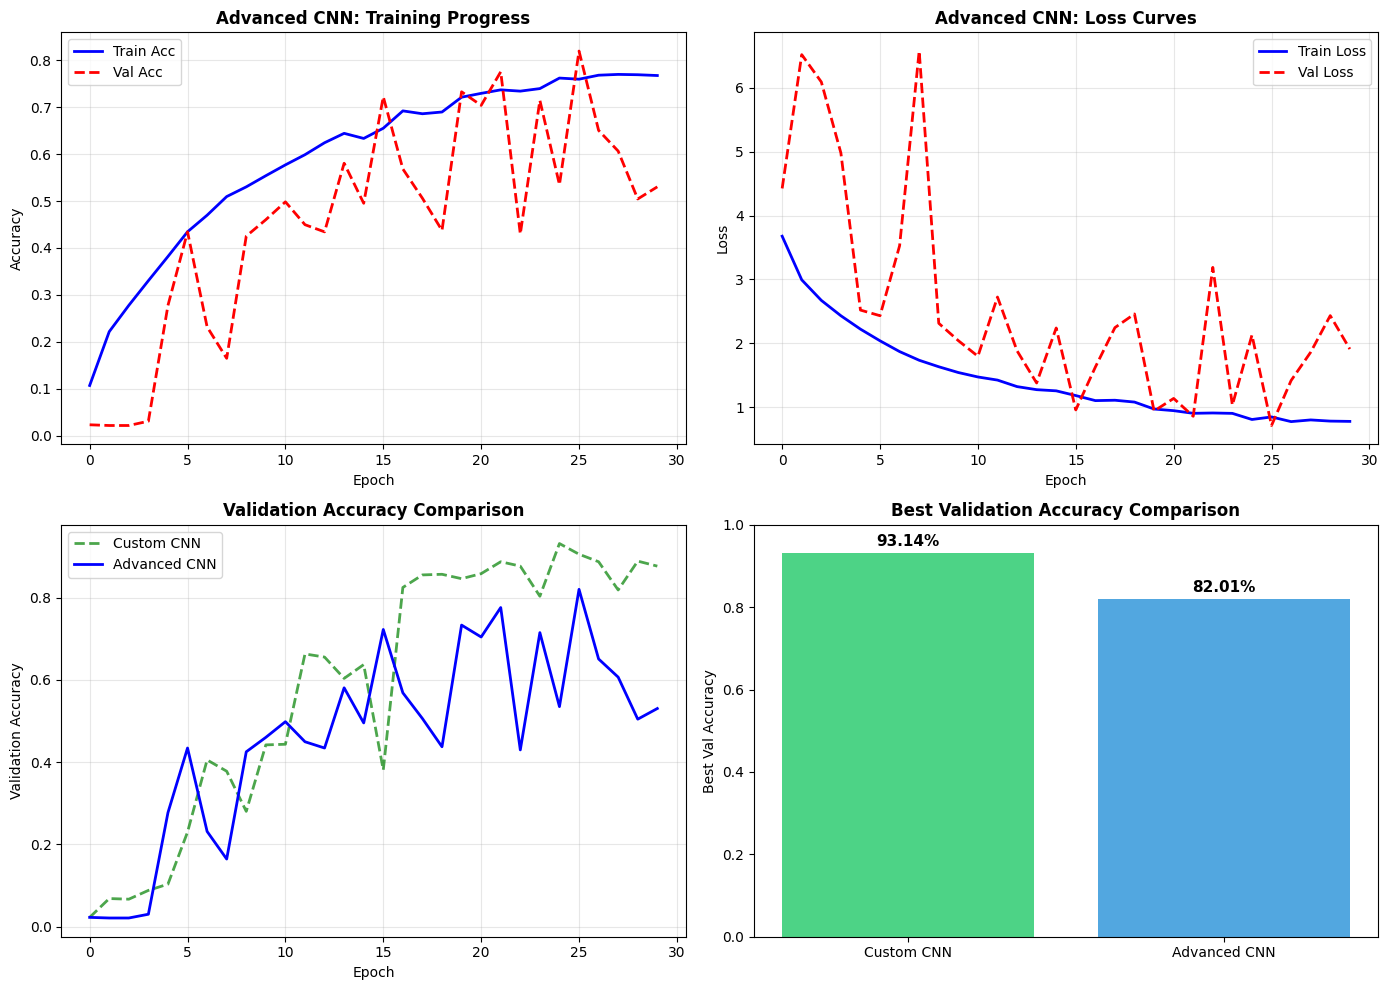


INSIGHTS: Advanced CNN vs Custom CNN

Advanced CNN Best Val Accuracy: 0.8201
Custom CNN Best Val Accuracy: 0.9314

Improvement: -0.1113 (-11.13%)


In [14]:
# Visualize Advanced CNN training and compare with Custom CNN
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Advanced CNN Training Curves
ax1 = axes[0, 0]
ax1.plot(history_advanced.history['accuracy'], 'b-', label='Train Acc', linewidth=2)
ax1.plot(history_advanced.history['val_accuracy'], 'r--', label='Val Acc', linewidth=2)
ax1.set_title('Advanced CNN: Training Progress', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Advanced CNN Loss
ax2 = axes[0, 1]
ax2.plot(history_advanced.history['loss'], 'b-', label='Train Loss', linewidth=2)
ax2.plot(history_advanced.history['val_loss'], 'r--', label='Val Loss', linewidth=2)
ax2.set_title('Advanced CNN: Loss Curves', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Comparison - Validation Accuracy
ax3 = axes[1, 0]
try:
    ax3.plot(history_cnn.history['val_accuracy'], 'g--', label='Custom CNN', linewidth=2, alpha=0.7)
except:
    pass
ax3.plot(history_advanced.history['val_accuracy'], 'b-', label='Advanced CNN', linewidth=2)
ax3.set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Bar comparison of best results
ax4 = axes[1, 1]
models_compare = ['Custom CNN', 'Advanced CNN']
try:
    best_accs = [
        max(history_cnn.history['val_accuracy']),
        max(history_advanced.history['val_accuracy'])
    ]
except:
    best_accs = [0, max(history_advanced.history['val_accuracy'])]

colors = ['#2ecc71', '#3498db']
bars = ax4.bar(models_compare, best_accs, color=colors, alpha=0.85)
ax4.set_title('Best Validation Accuracy Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Best Val Accuracy')
ax4.set_ylim([0, 1])

# Add value labels on bars
for bar, acc in zip(bars, best_accs):
    height = bar.get_height()
    ax4.annotate(f'{acc:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(LOGS_PATH / 'advanced_cnn_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("INSIGHTS: Advanced CNN vs Custom CNN")
print("="*80)
print(f"\nAdvanced CNN Best Val Accuracy: {max(history_advanced.history['val_accuracy']):.4f}")
try:
    print(f"Custom CNN Best Val Accuracy: {max(history_cnn.history['val_accuracy']):.4f}")
    improvement = max(history_advanced.history['val_accuracy']) - max(history_cnn.history['val_accuracy'])
    print(f"\nImprovement: {improvement:+.4f} ({improvement*100:+.2f}%)")
except:
    print("Custom CNN history not available for comparison")

In [15]:
# Generate detailed performance insights
print("="*80)
print("ADVANCED CNN - DETAILED PERFORMANCE ANALYSIS")
print("="*80)

# Training metrics
final_train_acc = history_advanced.history['accuracy'][-1]
final_val_acc = history_advanced.history['val_accuracy'][-1]
best_val_acc = max(history_advanced.history['val_accuracy'])
best_epoch = history_advanced.history['val_accuracy'].index(best_val_acc) + 1
total_epochs = len(history_advanced.history['accuracy'])

print(f"\nModel saved to: {MODELS_PATH / 'advanced_cnn_best.keras'}")

ADVANCED CNN - DETAILED PERFORMANCE ANALYSIS

Model saved to: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/models/classification/advanced_cnn_best.keras


## Summary: All 5 Models


ALL MODELS COMPARISON
       model  best_val_acc
 MobileNetV2      0.998476
  Custom CNN      0.931402
Advanced CNN      0.820122
    ResNet50      0.621951
EfficientNet      0.060976


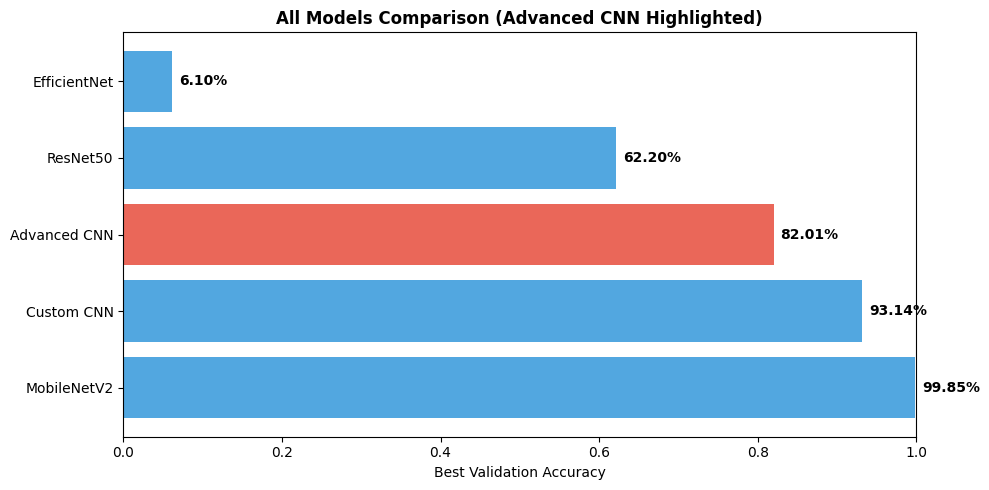


Best Model: MobileNetV2 with 99.85% validation accuracy


In [16]:
# Updated summary including Advanced CNN
try:
    all_results = [
        {'model': 'Custom CNN', 'best_val_acc': max(history_cnn.history['val_accuracy'])},
        {'model': 'ResNet50', 'best_val_acc': max(history_resnet.history['val_accuracy'])},
        {'model': 'EfficientNet', 'best_val_acc': max(history_eff.history['val_accuracy'])},
        {'model': 'MobileNetV2', 'best_val_acc': max(history_mobile.history['val_accuracy'])},
        {'model': 'Advanced CNN', 'best_val_acc': max(history_advanced.history['val_accuracy'])},
    ]
except:
    all_results = [
        {'model': 'Advanced CNN', 'best_val_acc': max(history_advanced.history['val_accuracy'])},
    ]
    print("Note: Some model histories not available. Showing Advanced CNN only.")

df_all = pd.DataFrame(all_results).sort_values('best_val_acc', ascending=False)
print("\n" + "="*80)
print("ALL MODELS COMPARISON")
print("="*80)
print(df_all.to_string(index=False))

# Bar chart
plt.figure(figsize=(10, 5))
colors = ['#e74c3c' if 'Advanced' in m else '#3498db' for m in df_all['model']]
bars = plt.barh(df_all['model'], df_all['best_val_acc'], color=colors, alpha=0.85)
plt.xlabel('Best Validation Accuracy')
plt.title('All Models Comparison (Advanced CNN Highlighted)', fontweight='bold')
plt.xlim([0, 1])

for bar, acc in zip(bars, df_all['best_val_acc']):
    width = bar.get_width()
    plt.annotate(f'{acc:.2%}',
                xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0),
                textcoords="offset points",
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(LOGS_PATH / 'all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

best = df_all.iloc[0]
print(f"\nBest Model: {best['model']} with {best['best_val_acc']:.2%} validation accuracy")